# [EXPLORATION-08] News_Summary

**텍스트 요약(Text Summarization)**이란 긴 길이의 문서(Document) 원문을 핵심 주제만으로 구성된 짧은 요약(Summary) 문장들로 변환하는 것이다.


텍스트 요약은 크게 추출적 요약(extractive summarization)과 추상적 요약(abstractive summarization)으로 나뉜다.
* **추출적 요약(Extractive Summarization)** : 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법
* **추상적 요약(Abstractive Summarization)** : 원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법

뉴스기사 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해본다.

In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. 데이터 수집하기

In [3]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


* nltk패키지에서 불용어 사전 다운로드
* urllib을 이용하여 뉴스 기사 데이터를 다운로드

In [4]:
data.sample(10)

,headlines,text
72758,"Women tortured, gang raped in Syrian govt pris...",A report by Syrian NGO Lawyers and Doctors for...
69237,What was Viagra doing in godman's room: Rakhi ...,"Rakhi Sawant, while revealing that she found V..."
48074,Pak lists 26/11 mastermind Hafiz Saeed's JuD a...,Pakistan's President Mamnoon Hussain has signe...
82099,Hot air balloon with 17 tourists crashes into ...,Seventeen tourists flying in a hot air balloon...
19930,Army orders action against Major Gogoi who met...,Indian Army ordered disciplinary action agains...
56121,Google to shut down augmented reality platform...,Technology giant Google has announced that it ...
59198,Courts cannot force husband to keep his wife: ...,The Supreme Court has observed that courts can...
22010,Vijay Mallya's London mansion has a gold toile...,Beleaguered liquor baron Vijay Mallya's London...
460,Hand that touches Hindu girl should be cut: An...,Union Minister Anantkumar Hegde on Sunday said...
32632,Minister confirms no deaths after saying 27 di...,A day after confirming 27 people were charred ...


해당 데이터는 text와 headlines 두 가지 열로 구성되어 있음.

* **추상적 요약** : text를 본문, headlines를 이미 요약된 데이터로 취급하여 모델을 학습
* **추출적 요약** : 오직 text열만을 사용

# 2. 데이터 전처리하기 (추상적 요약)

데이터 전처리 과정은 크게 세 과정으로 나눠서 진행된다.

1. 데이터 정리
2. 훈련 데이터와 데스트 데이터 분할
3. 정수 인코딩

# 2.1 데이터 전처리하기 - 데이터 정리

## 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


중복을 제외한다면 text에는 98,360개, headlines에는 98,280개의 유니크한 데이터가 존재.
headlines에는 간단한 요약들도 많아서 Text가 달라도 headlines는 동일할 수 있다. 하지만 Text 자체가 중복이 된 경우는 중복 샘플이므로 제거해야한다.

* 데이터프레임의 `drop_duplicates()`를 사용하면, 손쉽게 중복 샘플을 제거가능.
* 전체 샘플수는 98401개 이므로 text 열에서 41개 중복이 존재하는 것을 알 수 있음.

In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


* 데이터프레임에 Null 값이 있는지 확인하는 방법은 `.isnull().sum()`을 사용하면 알아볼 수 있음.

In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


* 결측치가 존재하지 않음.

## 텍스트 정규화와 불용어 제거

**텍스트 정규화(text normalization)** 란, 같은 의미이지만 다른 표현으로 사용되는 단어들을 같은 단어로 통일시켜주는 역할로, `it'll` = `it will`, `mustn't` = `must not` 와 같은 의미의 표현들을 통일시키는 과정. 텍스트 정규화를 통해 기계의 연산량을 줄일 수 있다.

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


**불용어** 란 자연어 처리를 할 때 의미를 분석하고 요약하는 데는 거의 의미가 없는 단어이다.

* NLTK 에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거한다.
* 불용어 리스트에는 총 179개의 불용어가 존재

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

데이터 전처리 함수 `preprocess_sentence`를 생성한다.
* 텍스트 소문자화
* html 태그 제거
* 괄호로 닫힌 문자열 (...) 제거
* 정규 표현식을 통해 각종 특수문자 제거
* 소유격 제거


이후, if 조건문을 이용하여 text에 있는 불용어를 제거하고, headlines에 있는 불용어는 제거하지 않음
* **text** 데이터만 불용어 제거하기 위해 함수의 인자로 `remove_stopwords` 추가
* Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 **headlines**에는 남아 있는 게 더 좋음

In [11]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

* 전체 text에 대하여 전처리 과정
* 전처리 과정을 거친 text 데이터는 clean_text라는 빈 리스트에 추가
* 불용어 제거, `remove_stopwords=True`

In [13]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

* 전체 headlines에 대하여 전처리 과정
* 전처리 과정을 거친 headlines 데이터는 clean_headlines 이라는 빈 리스트에 추가
* 불용어 제거 X, `remove_stopwords=False`

In [15]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


* 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있다. 이렇게 되면 샘플 자체가 빈 값을 가지게 된다.

* 이후 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체한다.

In [16]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

* dataframe 내에 NULL 값이 존재하는지 확인

In [17]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

# 2.2 데이터 전처리하기 - 훈련 데이터와 데스트 데이터 분할

## 샘플의 최대 길이 정하기

* 필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해준다.
* `text` 와 `headlines` 의 최소, 최대, 평균 길이를 구하고 길이 분포를 시각화해본다.

text 의 최소 길이 : 1
text 의 최대 길이 : 60
text 의 평균 길이 : 35.09968483123221
headlines 의 최소 길이 : 1
headlines 의 최대 길이 : 16
headlines 의 평균 길이 : 9.299532330215534


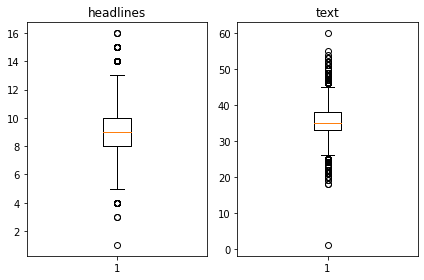

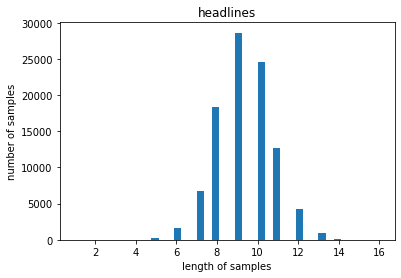

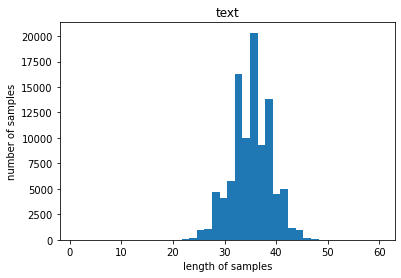

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('text 의 최소 길이 : {}'.format(np.min(text_len)))
print('text 의 최대 길이 : {}'.format(np.max(text_len)))
print('text 의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines 의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines 의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines 의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* `text`의 경우, 대체적으로 25 ~ 45 사이의 길이 분포를 구성
* `headlines`의 경우, 대체적으로 6 ~ 13 사이의 길이 분포를 구성text에 비해 길이가 상대적으로 짧음

* text와 headlines의 적절한 최대 길이를 임의로 설정

In [27]:
text_max_len = 44
headlines_max_len = 12

In [28]:
def below_threshold_len(max_len, nested_list):  # 데이터의 몇 %가 해당하는지 계산하는 함수
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [29]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 44 이하인 샘플의 비율: 0.9933712891419276
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


* text와 headlines의 약 98% 이상의 데이터들이 포함되는 것을 확인


## 최대길이 적용

* 설정한 최대 길이보다 긴 데이터들은 dataframe에서 제외
* 최종적으로 남는 **샘플의 수는 96,538개**

In [30]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플 수 :',(len(data)))

전체 샘플 수 : 96538


## 시작 토큰과 종료 토큰 추가하기

* seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가해야한다.
* 시작 토큰은 `sostoken`, 종료 토큰은 `eostoken`이라 임의로 명명하고 앞, 뒤로 추가한다.

In [31]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


## Encoder 및 Decoder 생성 + 섞기

* 인코더의 입력, 디코더의 입력, 디코더의 레이블을 numpy 타입으로 저장
* 훈련 데이터와 테스트 데이터를 분리하기 전에, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 선언
* 앞서 만든 정수 시퀀스를 이용하여, 데이터의 샘플 순서를 정의
* 샘플을 섞어주는 역할을 수행

In [32]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장 
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

[29236 29113 45462 ... 53232 90746 21530]


## 훈련 데이터와 테스트 데이터 분할

* 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리할 예정
* 전체 데이터 크기에 0.2를 곱하여, 테스트 데이터의 크기를 정의
* 앞서 정의한 테스트 데이터의 갯수를 이용하여 전체 데이터를 훈련 데이터와 테스트 데이터로 양분
* 총 훈련 데이터는 77,231개이고, 테스트 데이터는 19,307개

In [33]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

테스트 데이터의 수 : 19307
훈련 데이터의 개수 : 77231
훈련 레이블의 개수 : 77231
테스트 데이터의 개수 : 19307
테스트 레이블의 개수 : 19307


# 2.3 데이터 전처리하기 - 정수 인코딩

## 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [34]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

* 현재 생성된 단어 집합은 `src_tokenizer.word_index` 에 저장되어 있다.

* 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외한다.

* `src_tokenizer.word_counts.items()` 를 사용하여 등장 빈도수가 8회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해본다.

In [40]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68761
등장 빈도가 7번 이하인 희귀 단어의 수: 48297
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20464
단어 집합에서 희귀 단어의 비율: 70.23894358720787
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.8959070984528728


* 등장 빈도가 threshold 값인 7회 이하인 단어들은 단어 집합에서 약 70% 를 차지함.
* 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.89% 밖에 되지 않음.

등장 빈도가 7회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거한다.

단어 집합의 크기를 20,000으로 제한한다.

In [41]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [42]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[0])

[536, 687, 1270, 1587, 2323, 4683, 4724, 1417, 456, 85, 92, 168, 386, 2992, 176, 416, 5812, 838, 2855, 55, 671, 6901, 4, 1602, 416, 3900, 572, 536, 92, 820, 6179, 416, 2812]


## keras의 토크나이저를 이용하여, decoder_input에 대해서도 똑같은 작업을 수행

In [43]:
# 전체 단어 집합과 각 단어에 대한 빈도수를 계산
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [44]:
# 등장 빈도수가 8회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29762
등장 빈도가 6번 이하인 희귀 단어의 수: 20328
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9434
단어 집합에서 희귀 단어의 비율: 68.3018614340434
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.382085905690958


In [45]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[0])
print('target')
print('decoder ',decoder_target_train[0])

input
input  [1, 3648, 636, 426, 107, 80, 6118, 24, 215, 7, 1537, 244]
target
decoder  [3648, 636, 426, 107, 80, 6118, 24, 215, 7, 1537, 244, 2]


* 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다.

* decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이므로 길이가 0이 된 요악문의 실제 길이는 1로 나올 것이다.

* 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장하고 샘플들은 모두 삭제한다.

In [46]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 77231
훈련 레이블의 개수 : 77231
테스트 데이터의 개수 : 19306
테스트 레이블의 개수 : 19306


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## 패딩 추가

* 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해준다.

In [47]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# 3. 모델 설계

## Encoder Model 정의

* 임베딩 벡터의 차원을 128로 정의하고, hidden state의 크기를 256으로 정의
* 이후, 인코더 부분의 LSTM은 총 3개의 층으로 구성
* 인코더의 최종 출력 벡터는 디코더로 보낼 예정

In [48]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

## Decoder Model 정의

* 디코더의 임베딩 층을 설계하는 것은 인코더와 동일
* LSTM 층은 initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줌

In [49]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층 설계
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

## Encoder와 Decoder 합치기

In [50]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 44)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 44, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 44, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## Attension Model 어텐션 메커니즘 사용하기 (추상적 요약)

* model에서 어텐션 함수를 이용할 예정

In [52]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 44)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 44, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 44, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# 4. 모델 훈련

In [53]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
302/302 [==============================] - 203s 618ms/step - loss: 5.5316 - val_loss: 5.1038
Epoch 2/50
302/302 [==============================] - 184s 610ms/step - loss: 4.9444 - val_loss: 4.7363
Epoch 3/50
302/302 [==============================] - 184s 608ms/step - loss: 4.6196 - val_loss: 4.4704
Epoch 4/50
302/302 [==============================] - 183s 606ms/step - loss: 4.3575 - val_loss: 4.2833
Epoch 5/50
302/302 [==============================] - 183s 606ms/step - loss: 4.1564 - val_loss: 4.1320
Epoch 6/50
302/302 [==============================] - 183s 606ms/step - loss: 3.9881 - val_loss: 4.0299
Epoch 7/50
302/302 [==============================] - 182s 603ms/step - loss: 3.8453 - val_loss: 3.9399
Epoch 8/50
302/302 [==============================] - 182s 603ms/step - loss: 3.7226 - val_loss: 3.8784
Epoch 9/50
302/302 [==============================] - 182s 603ms/step - loss: 3.6157 - val_loss: 3.8113
Epoch 10/50
302/302 [==============================] - 182s 604m

* 설계한 model을 훈련
* early stopping 기능을 이용하여, validation loss가 증가하는 현상이 2회 관측될 시, 학습을 종료
* 최종적으로, model이 최적점에서 훈련을 종료하는 역할을 수행
* model의 loss는 약 2.5661이지만, validation loss는 3.5296으로 둘 사이의 격차가 큼

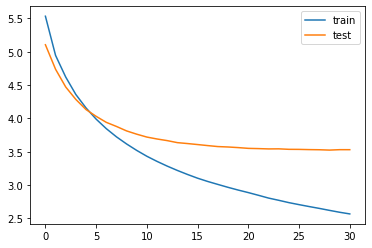

In [54]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

훈련 데이터와 테스트 데이터의 loss를 시각화
훈련 데이터와 테스트 데이터 loss의 격차를 보면, 훈련 데이터가 overfitting이 되었다고 판단할 수 있음

# 5. 인퍼런스 모델 구현

## word2index, index2word 구하기

In [55]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

## Encoder Model

In [56]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

## Decoder Model

In [58]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

## word를 Sequence로 만드는 함수

In [64]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 6. 모델 테스트

주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만든다.

이때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만든다.

In [65]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [72]:
for i in range(20, 40):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : facebook coo sheryl sandberg twitter co founder ceo jack dorsey seek election walt disney board according filing disney said become increasingly difficult two avoid conflicts relating board matters former starbucks ceo smith also leave board following rules specify retirement age 
실제 요약 : fb coo twitter ceo to leave disney board 
예측 요약 :  twitter ceo quits facebook over paris deal


원문 : irrfan khan saba qamar starrer hindi medium named best film rd edition filmfare awards irrfan named best actor hindi medium vidya balan best actress tumhari sulu meanwhile rajkummar rao starrer newton best film filmfare award 
실제 요약 : hindi medium named best film at filmfare awards 
예측 요약 :  irrfan irrfan khan to star in hindi medium report


원문 : student kolkata st paul cathedral mission college allegedly stripped naked filmed seniors questioned funds used college fest filed police complaint video incident circulated college west bengal education minister partha chatterjee said strict action take

# 7. 추출적 요약 (Extractive Summarization)

* 패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 간단하게 구현가능.

In [68]:
from summa.summarizer import summarize
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [69]:
data['summary'] = data['text'].apply(lambda x: summarize(x, ratio=0.5))

In [70]:
data.sample(10)

,headlines,text,summary
20523,US man yells 'Jesus is coming' before stabbing...,A man was shot in the leg by his neighbour in ...,A man was shot in the leg by his neighbour in ...
68255,World Tourism Day celebrated on September 27,World Tourism Day is celebrated on September 2...,World Tourism Day is celebrated on September 2...
65102,Taj Mahal sits on stolen property: Subramanian...,BJP leader Subramanian Swamy has alleged Taj M...,He said there are documents that also suggest ...
10921,"Thor actor shares video of India traffic, call...","'Thor' actor Chris Hemsworth, who's in India t...","In another video, Hemsworth said, ""No one's......"
10102,PM Modi is my friend and now Ivanka's: Trump a...,While introducing his daughter Ivanka to India...,While introducing his daughter Ivanka to India...
89824,Scientists generate hydrogen fuel from pollute...,Belgian scientists have developed a device tha...,The compartments for purifying air and storing...
18897,I've become Shah Rukh Khan because of Salman a...,"Actor Shah Rukh Khan, who recently appeared on...","Actor Shah Rukh Khan, who recently appeared on..."
38443,"Mumbai witnessed 12 major fires, 22 deaths in ...",Mumbai has witnessed 12 major fires which resu...,Mumbai has witnessed 12 major fires which resu...
16064,Doctors treat patients under candlelight due t...,Doctors at a government hospital in Odisha's M...,Doctors at a government hospital in Odisha's M...
60401,What was the answer that won Manushi the Miss ...,"In Miss World 2017's final round, India's Manu...",


In [74]:
for i in range(40, 60):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("추출 요약 :", data['summary'][i])
    print("\n")

원문 : Ex-ICICI Bank CEO Chanda Kochhar said she's "utterly disappointed, hurt and shocked" by the bank's decision to terminate her. Kochhar said she served ICICI for 34 years with utmost honesty and integrity and that ultimately truth will prevail. Adding that she hasn't been given a copy of the independent probe report, Kochhar said none of ICICI's credit decisions are unilateral
실제 요약 : Shocked, hurt by ICICI's decision, truth will prevail: Kochhar
추출 요약 : Adding that she hasn't been given a copy of the independent probe report, Kochhar said none of ICICI's credit decisions are unilateral


원문 : Swedish multinational fast-fashion brand Hennes & Mauritz AB (H&M) has hired Christopher Wylie, the whistleblower who exposed Facebook's Cambridge Analytica data scandal. WylieÃ¢ÂÂs focus will be to help get better insights on customers, products and markets and support work on sustainable and ethical artificial intelligence, H&M spokesperson said. Wylie is a former employee of Cambridge Ana

# 8. 결론 및 정리


## 추상적 요약(Abstractive Summarization)
원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법

* 원문 : user united states claimed apple iphone exploded allegedly updated ios posted several photos exploded phone apple responded definitely expected behaviour update completed soon phone turned started smoke caught fire user said 

* 실제 요약 : apple iphone explodes after update in the us 

* 예측 요약 :  apple iphone explodes users to unlock iphone location


위 예측결과를 보면, 추상적 요약에서는 키워드를 찾아내고 그것을 요약할 수 있는 새로운 단어를 만들어 요약을 하는 모습을 확인 할 수 있다.
하지만 위와 같이 아주 대략적인 내용 또는 범주는 비슷하지만, 구체적으로 살펴보면 원문의 내용과는 연관성이 떨어지는 요약을 하는 경우도 다수 확인 할 수 있다.
또한 원문과는 상관없는 이상한 요약을 예측한 경우도 존재했다.


## 추출적 요약(Extractive Summarization)
원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법

* 원문 : Railway police has rescued a woman travelling on a train in Chennai who got her leg stuck inside the commode of a toilet. After being caught inside the commode hole, she struggled to remove her leg and following failed attempts, she shouted for help, reports said. Railway police used a cutter to pry open the commode and freed her leg.
* 실제 요약 : Railway police rescues woman with leg stuck in train toilet
* 추출 요약 : Railway police has rescued a woman travelling on a train in Chennai who got her leg stuck inside the commode of a toilet.

위의 예측 결과를 보면, 추출적 요약에서는 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약이 된 것을 확인 할 수 있다. 하지만 이 결과 이외의 다른 결과를 기준으로는 다소 어색하거나 의미가 이상한 것 들이 많다. 그나마 추상적 요약보다는 좋은 것 같다.


## 결론

**결론적으로**, 추출적 요약 모델이 더 좋거나 적합하다 생각되지만, 모델의 강건성이나 정확성을 생각한다면 큰 의미는 없는 것 같다.


## 추가생각

model 학습 결과를 보면 성능이 그닥 좋지는 못 한것 같다. 이를 해결하기 위해서는 다양한 기법을 추가하면 될 것 같지만 아주 nice하게 성능이 좋아 질 것이라고 생각하지 않는다. 더군다나 하이퍼파라미터 설정도 주관이 너무 담겨있어서 혼란스럽다. NLP모델은 개인간, 주관이 담기기 때문에 좋은 모델을 작성한다 하더라고 정말 좋은 모델인지, 신뢰할 수 있는지 의문이 든다.